# Car Price prediction

In [1]:
!pip install -q tensorflow==2.3
!pip install albumentations -q
!pip install -q pymorphy2

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import math
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
#rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option('display.max_columns', None)

!pip freeze > requirements.txt

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [4]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный  

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [6]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [8]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [9]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Пропусков в трейне особо нет, только "владение". Потому будем смотреть на распределение признаков и количество значений.

In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [11]:
def num_describer(df,param,bins=20):
    nulls=round(df[param].isnull().sum()/len(df[param]),4)
    low = df[param].min()
    median = df[param].median()
    mean = df[param].mean()
    hight = df[param].max()
    IQR = df[param].quantile(
        0.75) - df[param].quantile(0.25)
    perc25 = df[param].quantile(0.25)
    perc75 = df[param].quantile(0.75)
    #blowout=len(df[(df[param]<perc25 - 1.5*IQR)|(df[param]>perc75 + 1.5*IQR)])
    print('доля пропусков : {} \n\r'.format(nulls),
          'min : {} \n\r'.format(low),
          '25-й перцентиль: {} \n\r'.format(perc25),
          'медиана: {} \n\r'.format(median),
          'среднее: {} \n\r'.format(mean),
          'max : {} \n\r'.format(hight),
          '75-й перцентиль: {} \n\r'.format(perc75),
          "IQR: {} \n\r".format(IQR),
          "Границы выбросов: [{f}, {l}] \n\r".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR),
         )#'Количество выбросов: \n\r'.format(blowout))
    fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(8, 4))
    sns.distplot(df[param],ax=ax1)
    #ax1.hist(df[param],label = param,bins=bins)
    ax1.set_title('Распределение значений')
    ax1.legend()
    sns.distplot(np.log(df[param]+1),ax=ax2)
    #ax2.hist(np.log(df[param]+1),label = param,bins=bins)
    ax2.set_title('Логорифмированное Распределение значений')
    ax2.legend()
    #sns.distplot(df[param])
    plt.show()

In [12]:
def borders_of_outliers(d_df,columns, log = False):
    num_df = d_df[columns]
    list_of_names = list(num_df.columns)
    temp_dict = {}
    temp_dict['имя признака'] = list_of_names
    left_board=[]
    right_board=[]
    left_outliers=[]
    right_outliers=[]
    path_left_outliers=[]
    path_right_outliers=[]
    if log:
        log_left_board=[]
        log_right_board=[]
        log_left_outliers=[]
        log_right_outliers=[]
        log_path_left_outliers=[]
        log_path_right_outliers=[]
    for i in columns:
        IQR = num_df[i].quantile(0.75) - num_df[i].quantile(0.25)
        perc25 = num_df[i].quantile(0.25)
        perc75 = num_df[i].quantile(0.75)
        left_border = num_df[i].quantile(0.25) - 1.5*IQR
        right_border = perc75 + 1.5*IQR
        left_board.append(left_border)
        right_board.append(right_border)
        left_outliers.append((num_df[i]<left_border).sum())
        right_outliers.append((num_df[i]>right_border).sum())
        path_left_outliers.append((num_df[i]<left_border).sum()/len(num_df[i]))
        path_right_outliers.append((num_df[i]>right_border).sum()/len(num_df[i]))
        if log:
            num_df[i]=num_df[i].apply(lambda x: math.log(x+1))
            IQR = num_df[i].quantile(0.75) - num_df[i].quantile(0.25)
            perc25 = num_df[i].quantile(0.25)
            perc75 = num_df[i].quantile(0.75)
            left_border = num_df[i].quantile(0.25) - 1.5*IQR
            right_border = perc75 + 1.5*IQR
            log_left_board.append(left_border)
            log_right_board.append(right_border)
            log_left_outliers.append((num_df[i]<left_border).sum())
            log_right_outliers.append((num_df[i]>right_border).sum())
            log_path_left_outliers.append((num_df[i]<left_border).sum()/len(num_df[i]))
            log_path_right_outliers.append((num_df[i]>right_border).sum()/len(num_df[i]))
        
    temp_dict['левая граница'] = left_board
    temp_dict['правая граница'] = right_board
    temp_dict['выбросов слева'] = left_outliers
    temp_dict['выбросов справа'] = right_outliers
    temp_dict['доля выбросов слева'] = path_left_outliers
    temp_dict['доля выбросов справа'] = path_right_outliers
    
    if log:
        temp_dict['левая граница с логарифмом'] = log_left_board
        temp_dict['правая граница с логарифмом'] = log_right_board
        temp_dict['выбросов слева с логарифмом'] = log_left_outliers
        temp_dict['выбросов справа с логарифмом'] = log_right_outliers
        temp_dict['доля выбросов слева с логарифмом'] = log_path_left_outliers
        temp_dict['доля выбросов справа с логарифмом'] = log_path_right_outliers
    
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    display(temp_df.T)
    
    return

In [13]:
def obj_param_describe(df,param,aim):
    title='Значения параметра {} и их распределение'.format(param)
    df[param].value_counts().plot.bar(title=title)
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.boxplot(x=param, y=aim, data=df)
    plt.xticks(rotation=90)

In [14]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 'name',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

In [15]:
def yaer_return(string):
    try:
        year=re.findall(r'(\d+)\s\w+',str(string))
        if len(year)==1:
            return round(int(year[0])/12,2)
        else:
            return round(int(year[0])+(int(year[1])/12),2)
    except:
        return 0

def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    df_output['model_type']=df_output['name'].apply(lambda x: str(x).split(' ')[0])
    categorical_features.append('model_type')
    df_output=df_output.drop(['name'],axis=1)
    categorical_features.remove('name')
    
    df_output.enginePower=df_output.enginePower.apply(lambda x: str(x).split(' ')[0])
    df_output.enginePower=df_output.enginePower.astype(int)
    df_output.engineDisplacement=df_output.engineDisplacement.apply(lambda x: str(x).split(' ')[0])
    df_output.engineDisplacement=df_output.engineDisplacement.replace('undefined','0.0')
    df_output.engineDisplacement=df_output.engineDisplacement.astype(float)
    numerical_features.append('engineDisplacement')
    categorical_features.remove('engineDisplacement')
    
    df_output['Владельцы'].fillna('3 или более', inplace=True)
    
    df_output['Владение_num']=df_output['Владение'].map(yaer_return)
    df_output=df_output.drop(['Владение'],axis=1)
    categorical_features.remove('Владение')
    numerical_features.append('Владение_num')
    
    df_output['vehicle_age']=2021-df_output['productionDate']
    numerical_features.append('vehicle_age')
    
    df_output['year_mileage']=round(df_output['mileage']/df_output['vehicle_age'],2)
    numerical_features.append('year_mileage')

    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    df_output.bodyType=df_output.bodyType.apply(lambda x: str(x).split(' ')[0])
    

    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)

    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
     

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)

    
    return df_output

In [16]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,mileage,modelDate,productionDate,sample,price,Владение_num,vehicle_age,year_mileage,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,enginePower_0,enginePower_1,enginePower_2,enginePower_3,enginePower_4,enginePower_5,enginePower_6,enginePower_7,enginePower_8,enginePower_9,enginePower_10,enginePower_11,enginePower_12,enginePower_13,enginePower_14,enginePower_15,enginePower_16,enginePower_17,enginePower_18,enginePower_19,enginePower_20,enginePower_21,enginePower_22,enginePower_23,enginePower_24,enginePower_25,enginePower_26,enginePower_27,enginePower_28,enginePower_29,enginePower_30,enginePower_31,enginePower_32,enginePower_33,enginePower_34,enginePower_35,enginePower_36,enginePower_37,enginePower_38,enginePower_39,enginePower_40,enginePower_41,enginePower_42,enginePower_43,enginePower_44,enginePower_45,enginePower_46,enginePower_47,enginePower_48,enginePower_49,enginePower_50,enginePower_51,enginePower_52,enginePower_53,enginePower_54,enginePower_55,enginePower_56,enginePower_57,enginePower_58,enginePower_59,enginePower_60,enginePower_61,enginePower_62,enginePower_63,enginePower_64,enginePower_65,enginePower_66,enginePower_67,enginePower_68,enginePower_69,enginePower_70,enginePower_71,enginePower_72,enginePower_73,enginePower_74,enginePower_75,enginePower_76,enginePower_77,enginePower_78,enginePower_79,enginePower_80,enginePower_81,enginePower_82,enginePower_83,enginePower_84,enginePower_85,enginePower_86,enginePower_87,enginePower_88,enginePower_89,enginePower_90,enginePower_91,enginePower_92,enginePower_93,enginePower_94,enginePower_95,enginePower_96,enginePower_97,enginePower_98,enginePower_99,enginePower_100,enginePower_101,enginePower_102,enginePower_103,enginePower_104,enginePower_105,enginePower_106,enginePower_107,enginePower_108,enginePower_109,enginePower_110,enginePower_111,enginePower_112,enginePower_113,enginePower_114,enginePower_115,enginePower_116,enginePower_117,enginePower_118,enginePower_119,enginePower_120,enginePower_121,enginePower_122,enginePower_123,enginePower_124,enginePower_125,enginePower_126,enginePower_127,enginePower_128,enginePower_129,enginePower_130,enginePower_131,enginePower_132,enginePower_133,enginePower_134,enginePower_135,enginePower_136,enginePower_137,enginePower_138,enginePower_139,enginePower_140,enginePower_141,enginePower_142,enginePower_143,enginePower_144,enginePower_145,enginePower_146,enginePower_147,enginePower_148,enginePower_149,enginePower_150,enginePower_151,enginePower_152,enginePower_153,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,

In [17]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 575 entries, engineDisplacement to model_type_235
dtypes: float64(8), int64(1), uint8(566)
memory usage: 5.1 MB


## Split data

In [18]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [19]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 574 entries, engineDisplacement to model_type_235
dtypes: float64(8), uint8(566)
memory usage: 1.0 MB


# Model : CatBoostRegressor

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [21]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=12,
                          learning_rate = 0.03,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )


model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         
         )#12.63%



0:	learn: 0.9824898	test: 1.0059374	best: 1.0059374 (0)	total: 56.8ms	remaining: 4m 43s
100:	learn: 0.2905828	test: 0.2883174	best: 0.2882884 (99)	total: 538ms	remaining: 26.1s
200:	learn: 0.2258313	test: 0.2222447	best: 0.2222020 (198)	total: 993ms	remaining: 23.7s
300:	learn: 0.1935293	test: 0.1911621	best: 0.1911621 (300)	total: 1.45s	remaining: 22.6s
400:	learn: 0.1797481	test: 0.1781469	best: 0.1781469 (400)	total: 1.91s	remaining: 21.9s
500:	learn: 0.1693899	test: 0.1686176	best: 0.1686176 (500)	total: 2.36s	remaining: 21.2s
600:	learn: 0.1623202	test: 0.1626005	best: 0.1626005 (600)	total: 2.82s	remaining: 20.7s
700:	learn: 0.1560434	test: 0.1579145	best: 0.1579145 (700)	total: 3.28s	remaining: 20.1s
800:	learn: 0.1510976	test: 0.1534147	best: 0.1534147 (800)	total: 3.74s	remaining: 19.6s
900:	learn: 0.1458580	test: 0.1498874	best: 0.1498023 (898)	total: 4.2s	remaining: 19.1s
1000:	learn: 0.1413721	test: 0.1467756	best: 0.1467756 (1000)	total: 4.66s	remaining: 18.6s
1100:	learn:

In [22]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.49%


### Submission

In [23]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [24]:
X_train.head(5)

,engineDisplacement,mileage,modelDate,productionDate,Владение_num,vehicle_age,year_mileage,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,enginePower_0,enginePower_1,enginePower_2,enginePower_3,enginePower_4,enginePower_5,enginePower_6,enginePower_7,enginePower_8,enginePower_9,enginePower_10,enginePower_11,enginePower_12,enginePower_13,enginePower_14,enginePower_15,enginePower_16,enginePower_17,enginePower_18,enginePower_19,enginePower_20,enginePower_21,enginePower_22,enginePower_23,enginePower_24,enginePower_25,enginePower_26,enginePower_27,enginePower_28,enginePower_29,enginePower_30,enginePower_31,enginePower_32,enginePower_33,enginePower_34,enginePower_35,enginePower_36,enginePower_37,enginePower_38,enginePower_39,enginePower_40,enginePower_41,enginePower_42,enginePower_43,enginePower_44,enginePower_45,enginePower_46,enginePower_47,enginePower_48,enginePower_49,enginePower_50,enginePower_51,enginePower_52,enginePower_53,enginePower_54,enginePower_55,enginePower_56,enginePower_57,enginePower_58,enginePower_59,enginePower_60,enginePower_61,enginePower_62,enginePower_63,enginePower_64,enginePower_65,enginePower_66,enginePower_67,enginePower_68,enginePower_69,enginePower_70,enginePower_71,enginePower_72,enginePower_73,enginePower_74,enginePower_75,enginePower_76,enginePower_77,enginePower_78,enginePower_79,enginePower_80,enginePower_81,enginePower_82,enginePower_83,enginePower_84,enginePower_85,enginePower_86,enginePower_87,enginePower_88,enginePower_89,enginePower_90,enginePower_91,enginePower_92,enginePower_93,enginePower_94,enginePower_95,enginePower_96,enginePower_97,enginePower_98,enginePower_99,enginePower_100,enginePower_101,enginePower_102,enginePower_103,enginePower_104,enginePower_105,enginePower_106,enginePower_107,enginePower_108,enginePower_109,enginePower_110,enginePower_111,enginePower_112,enginePower_113,enginePower_114,enginePower_115,enginePower_116,enginePower_117,enginePower_118,enginePower_119,enginePower_120,enginePower_121,enginePower_122,enginePower_123,enginePower_124,enginePower_125,enginePower_126,enginePower_127,enginePower_128,enginePower_129,enginePower_130,enginePower_131,enginePower_132,enginePower_133,enginePower_134,enginePower_135,enginePower_136,enginePower_137,enginePower_138,enginePower_139,enginePower_140,enginePower_141,enginePower_142,enginePower_143,enginePower_144,enginePower_145,enginePower_146,enginePower_147,enginePower_148,enginePower_149,enginePower_150,enginePower_151,enginePower_152,enginePower_153,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86

## Simple Dense NN

In [25]:
X_train.shape[1]

573

In [26]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               293888    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 425,473
Trainable params: 425,473
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [29]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [30]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

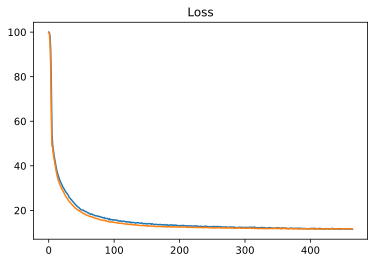

In [31]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [32]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [33]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.69%


In [34]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [35]:
#12.01% в стандартном нлп

In [36]:
#просто попытка удаления стопслов
#from nltk.corpus import stopwords
#print(stopwords.words("russian"))
#def remove_stopwords(string):
#    querywords = string.split()
#    resultwords  = [word for word in querywords if word.lower() not in stopwords.words("russian")]
#    result = ' '.join(resultwords)
#    return result

#data.description=data.description.map(remove_stopwords)
#результат с удалением стопслов 12.61

In [37]:

#from pymorphy2 import MorphAnalyzer
#from nltk.corpus import stopwords
#patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
#stopwords_ru = stopwords.words("russian")
#morph = MorphAnalyzer()
#def lemmatize(doc):
#    doc = re.sub(patterns, ' ', doc)
#    tokens = []
#    for token in doc.split():
#        if token and token not in stopwords_ru:
#            token = token.strip()
#            token = morph.normal_forms(token)[0]
#            
#            tokens.append(token)
#    res=" ".join(tokens)
#    return res
#
#print(data.description.iloc[1])
#print(lemmatize(data.description.iloc[1]))
#data.description=data.description.map(lemmatize)
#результат 12.11% с использванием стоп слов и лематизации

In [38]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [39]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [40]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.67 s, sys: 1.18 ms, total: 1.67 s
Wall time: 1.67 s


In [41]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [42]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.71 s, sys: 0 ns, total: 1.71 s
Wall time: 1.71 s


In [43]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [44]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [45]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [46]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [47]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [48]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [49]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [50]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 6s 482ms/step - loss: 99.9882 - MAPE: 99.9882 - val_loss: 99.8514 - val_MAPE: 99.8514
Epoch 2/500
12/12 [==============================] - 5s 398ms/step - loss: 98.6197 - MAPE: 98.6197 - val_loss: 93.6277 - val_MAPE: 93.6277
Epoch 3/500
12/12 [==============================] - 5s 418ms/step - loss: 79.1537 - MAPE: 79.1537 - val_loss: 51.0215 - val_MAPE: 51.0215
Epoch 4/500
12/12 [==============================] - 5s 403ms/step - loss: 51.5916 - MAPE: 51.5916 - val_loss: 46.7054 - val_MAPE: 46.7054
Epoch 5/500
12/12 [==============================] - 5s 394ms/step - loss: 45.8613 - MAPE: 45.8613 - val_loss: 42.5681 - val_MAPE: 42.5681
Epoch 6/500
12/12 [==============================] - 5s 399ms/step - loss: 41.6075 - MAPE: 41.6075 - val_loss: 38.4102 - val_MAPE: 38.4102
Epoch 7/500
12/12 [==============================] - 5s 397ms/step - loss: 37.7300 - MAPE: 37.7300 - val_loss: 34.6875 - val_MAPE: 34.6875
Epoch 8/500
12/12 [========

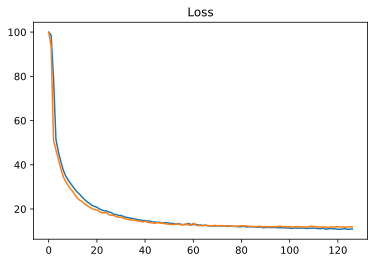

In [51]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [52]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [53]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.91%


In [54]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model 5: Добавляем картинки

### Data

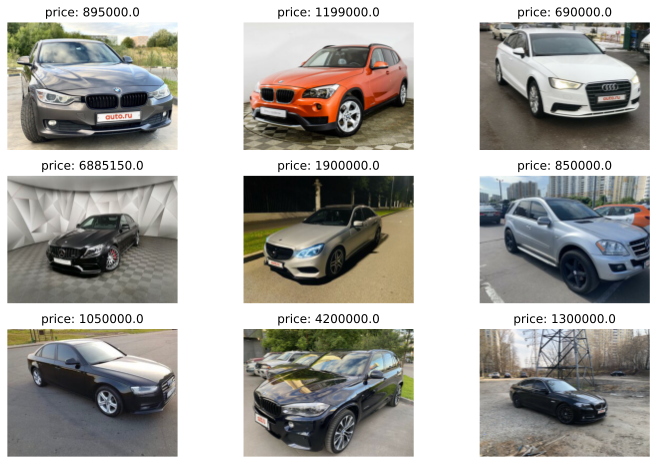

In [55]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [56]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

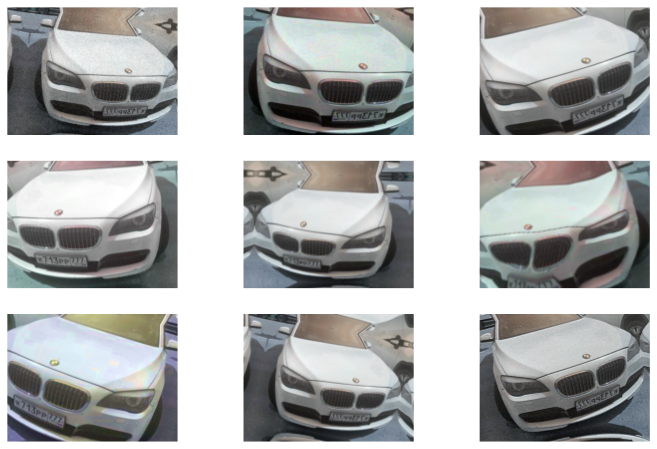

In [57]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [58]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [59]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [60]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [61]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB4(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

71688192/71686520 [==============================] - 4s 0us/step


In [62]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [63]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [64]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [65]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [66]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [67]:
history = model.fit(train_dataset.batch(30),
                    epochs=200,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/200
190/190 [==============================] - 183s 964ms/step - loss: 52.8509 - MAPE: 52.8509 - val_loss: 32.1548 - val_MAPE: 32.1548
Epoch 2/200
190/190 [==============================] - 178s 936ms/step - loss: 28.8959 - MAPE: 28.8959 - val_loss: 23.8457 - val_MAPE: 23.8457
Epoch 3/200
190/190 [==============================] - 177s 932ms/step - loss: 22.7372 - MAPE: 22.7372 - val_loss: 19.1657 - val_MAPE: 19.1657
Epoch 4/200
190/190 [==============================] - 177s 932ms/step - loss: 19.7481 - MAPE: 19.7481 - val_loss: 17.0959 - val_MAPE: 17.0959
Epoch 5/200
190/190 [==============================] - 178s 935ms/step - loss: 17.7753 - MAPE: 17.7753 - val_loss: 15.6480 - val_MAPE: 15.6480
Epoch 6/200
190/190 [==============================] - 178s 936ms/step - loss: 16.2901 - MAPE: 16.2901 - val_loss: 15.0194 - val_MAPE: 15.0194
Epoch 7/200
190/190 [==============================] - 177s 932ms/step - loss: 15.4796 - MAPE: 15.4796 - val_loss: 13.9600 - val_MAPE: 13.9600

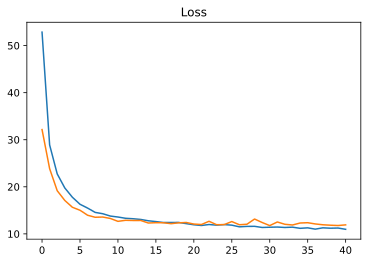

In [68]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [69]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [70]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.91%


In [71]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

In [72]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.92%


In [73]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [74]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [75]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [76]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [77]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 573)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          293888      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [78]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [79]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 41ms/step - loss: 99.9851 - MAPE: 99.9851 - val_loss: 99.8222 - val_MAPE: 99.8222
Epoch 2/500
12/12 [==============================] - 0s 11ms/step - loss: 98.4163 - MAPE: 98.4163 - val_loss: 92.7724 - val_MAPE: 92.7724
Epoch 3/500
12/12 [==============================] - 0s 11ms/step - loss: 76.5826 - MAPE: 76.5826 - val_loss: 49.6621 - val_MAPE: 49.6621
Epoch 4/500
12/12 [==============================] - 0s 11ms/step - loss: 51.2646 - MAPE: 51.2646 - val_loss: 46.1509 - val_MAPE: 46.1509
Epoch 5/500
12/12 [==============================] - 0s 11ms/step - loss: 44.9834 - MAPE: 44.9834 - val_loss: 42.1599 - val_MAPE: 42.1599
Epoch 6/500
12/12 [==============================] - 0s 11ms/step - loss: 40.8952 - MAPE: 40.8952 - val_loss: 37.9659 - val_MAPE: 37.9659
Epoch 7/500
12/12 [==============================] - 0s 11ms/step - loss: 37.1582 - MAPE: 37.1582 - val_loss: 34.6015 - val_MAPE: 34.6015
Epoch 8/500
12/12 [===============

In [80]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.39%


In [81]:
# 